# Введение

Задача с сорвенования
https://zindi.africa/competitions/predictive-insights-youth-income-prediction-challenge

Безработица среди молодежи и неполная занятость являются серьезной проблемой для любой развивающейся страны и служат важным предиктором экономического здоровья и процветания. Возможность предсказать и понять, какие молодые люди найдут работу, а каким потребуется дополнительная помощь, помогает способствовать принятию обоснованных решений, поддерживает расширение экономических прав и возможностей и позволяет молодым людям преуспевать в выбранной ими карьере.

Целью этой задачи является создание модели машинного обучения, которая прогнозирует занятость молодежи на основе данных исследований рынка труда в Южной Африке.

Это решение поможет таким организациям, как Predictive Insights, получить базовый прогноз результатов трудоустройства молодых людей, что позволит им разрабатывать и тестировать меры, которые помогут молодежи выйти на рынок труда или улучшить свои заработки.

Так же попробуем в отдельном ноутбуке кластеризовать опрошенных по социальным признакам.

# Данные

Данные для этой задачи получены в результате четырех раундов опроса молодежи на рынке труда Южной Африки, проводимых с интервалом в 6 месяцев. Каждый человек в наборе данных был опрошен за год до последующего опроса («исходные» данные). Задача в том, чтобы спрогнозировать, занят ли человек при последующем опросе, на основе его статуса на рынке труда и других характеристик во время базового исследования.

Обучающий набор состоит из одной строки или наблюдения для каждого человека — информация, собранная на исходном уровне, плюс только целевой результат (независимо от того, были ли они трудоустроены или нет) год спустя. Набор тестов состоит из данных, собранных на исходном уровне, без учета целевого результата.

Необходим прогноз, будет ли молодой человек трудоустроен через год после базового исследования, основываясь на его демографических характеристиках, предыдущем и текущем опыте на рынке труда и результатах образования, а также предоставить простой для понимания и содержательный анализ. 

<b>Описания полей:</b>

- <b> Target </b>- целевая перменная, будет трудоустроен человек в течение года: 1 - да, 0 - нет
- Person_id - Идентификатор человека
- Survey_date - Дата опроса
- Round - Раунд опроса
- Status - Тип занятости
- Tenure - Длительность статуса в днях. Если человек работает или учится, это то стаж работы или учебы, а если безработный, то, как давно человек без работы. Например, чем больше срок, тем лучше показатель для работающих и хуже для безработных.
- Geography - Годод/село
- Province - Регион ЮАР     
- Matric - Наличие аттестата об окончании школы ЮАР: 1 - да, 0 - нет
- Degree  - Наличие научной степени 
- Diploma - Наличие диплома о высшем образовании
- Schoolquintile - Квантиль школы в по систему ЮАР (см. примечание ниже)
- Math и Mathlit - два варианта математики, взятые в матрице. Ученики должны сдавать один тип и не могут оба
- Additional_lang - Школный бал в процентах по начальному англискому языку
 <br>Обратим внимание, что английский - официальный язык ЮАР, но по факту в рейтинге языков, на которых говорят граждане, он занимает пятое место. Это не самый распространённый язык для повседневного общения 
- Home_lang - Школный бал в процентах по угулбленному англискому языку
- Science - Школный бал в процентах по предмету "Наука" (В ЮАР в один предмет входят физика и химия)
- Female - Женский пол: 1 - да, 0 - мужской
- Sa_citizen  - Наличие гражданства ЮАР: 1 - да, 0- нет
- Birthyear - Год рождения
- Birthmonth - Месяц рождения  

<b>Примечание</b>

В Южной Африке система образования делит школы на пять квинтилей в зависимости от их социально-экономических условий. Школы квинтиля 1 (Q1), за которыми следуют школы Q2, являются самыми бедными и получают наибольшее государственное финансирование, в то время как школы Q4 и Q5 (платные школы) испытывают наименьшие экономические трудности и получают самое низкое финансирование.

# Разведочный анализ данных (EDA)

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import joblib

from functions import plot_text, normalize_target, check_chi2, barplot_group, fullfeat, check_overfitting, \
plot_confusion_matrix, duomatrix, get_metrics, replace_values
from get_metrics import get_metrics_classification
from sklearn.metrics import precision_score, recall_score, mean_absolute_error, accuracy_score, \
f1_score, log_loss, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_predict

import yaml
from yaml import load
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization import plot_optimization_history

from tqdm import tqdm_notebook

In [2]:
# Импортируем файл с параметрами
config_path = '/home/basil/Downloads/mlops/config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [3]:
preproc = config['preprocessing']
training = config['train']
df = pd.read_csv(preproc['train_path'])

In [4]:
# Общая информаця о признаках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Person_id        4020 non-null   object 
 1   Survey_date      4020 non-null   object 
 2   Round            4020 non-null   int64  
 3   Status           4020 non-null   object 
 4   Tenure           2626 non-null   float64
 5   Geography        4020 non-null   object 
 6   Province         4020 non-null   object 
 7   Matric           3012 non-null   float64
 8   Degree           2189 non-null   float64
 9   Diploma          2211 non-null   float64
 10  Schoolquintile   2359 non-null   float64
 11  Math             997 non-null    object 
 12  Mathlit          1353 non-null   object 
 13  Additional_lang  2018 non-null   object 
 14  Home_lang        381 non-null    object 
 15  Science          732 non-null    object 
 16  Female           4020 non-null   int64  
 17  Sa_citizen    

В некоторых столбцах есть пропуски в данных. Позже заполним их.
Так же есть плохо заполненные признаки (Math, Home_lang, Science). Пока не будем их удалять, посмотрим на них  тоже. В задаче кластеризации они могут оказаться важными.

In [5]:
# Описательные статистики для числовых признаков, в т. ч. бинаризованных.
df.describe()

Round       Tenure       Matric       Degree      Diploma  \
count  4020.000000  2626.000000  3012.000000  2189.000000  2211.000000   
mean      3.129851   582.883092     0.850598     0.078118     0.081411   
std       0.978014   621.220657     0.356544     0.268418     0.273527   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000    95.000000     1.000000     0.000000     0.000000   
50%       3.000000   395.000000     1.000000     0.000000     0.000000   
75%       4.000000   819.000000     1.000000     0.000000     0.000000   
max       4.000000  3560.000000     1.000000     1.000000     1.000000   

       Schoolquintile       Female   Sa_citizen    Birthyear   Birthmonth  \
count     2359.000000  4020.000000  4020.000000  4020.000000  4020.000000   
mean         2.696482     0.564428     0.999502  1997.462935     5.344030   
std          1.318409     0.495893     0.022302     4.378334     3.805916   
min          0.000000     0.000000     0.000000  1972.000000     1.000000   
25%          2.000000     0.000000     1.000000  1995.000000     1.000000   
50%          3.000000     1.000000     1.000000  1999.000000     5.000000   
75%          4.000000     1.000000     1.000000  2000.000000     9.000000   
max          5.000000     1.000000     1.000000  2004.000000    12.000000   

            Target  
count  4020.000000  
mean      0.271891  
std       0.444989  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Отрицательных значений в минимальных нет, минимальный год рождения 1972, максимальный 2004. Месяца аналогично 1 и 12. Видим, что среди опрошенных большую часть составляют молодые женщины, родившиеся в 2000 году и позже.

In [6]:
# Описательные статистики для категориальных признаков
df.describe(include=["object"])

Person_id Survey_date      Status Geography Province      Math  \
count            4020        4020        4020      4020     4020       997   
unique           4020          79           7         3        9         7   
top     Id_eqz61wz7yn  2023-02-13  unemployed     Urban  Gauteng  0 - 29 %   
freq                1         121        1775      2797     1170       321   

          Mathlit Additional_lang  Home_lang    Science  
count        1353            2018        381        732  
unique          7               6          6          7  
top     40 - 49 %       50 - 59 %  50 - 59 %  30 - 39 %  
freq          420             820        140        263

Уникальных значений категориальных признаков, которые можно использовать в исследовании, немного, до 7.
PersonID и Survey_date (Дата опроса) удалим, как не влияющие на исследование.

In [7]:
# Первые пять строк таблицы
df.head()

Person_id Survey_date  Round      Status  Tenure Geography  \
0  Id_eqz61wz7yn  2022-02-23      2    studying     NaN     Rural   
1  Id_kj5k3g5wud  2023-02-06      4  unemployed   427.0    Suburb   
2  Id_9h0isj38y4  2022-08-08      3       other     NaN     Urban   
3  Id_5ch3zwpdef  2022-03-16      2  unemployed   810.0     Urban   
4  Id_g4elxibjej  2023-03-22      4    studying     NaN     Urban   

       Province  Matric  Degree  Diploma  ...       Math Mathlit  \
0    Mpumalanga     1.0     0.0      0.0  ...   0 - 29 %     NaN   
1    North West     1.0     0.0      0.0  ...  30 - 39 %     NaN   
2    Free State     1.0     0.0      0.0  ...  30 - 39 %     NaN   
3  Eastern Cape     NaN     NaN      NaN  ...        NaN     NaN   
4       Limpopo     NaN     NaN      NaN  ...        NaN     NaN   

  Additional_lang Home_lang    Science Female  Sa_citizen  Birthyear  \
0       50 - 59 %       NaN   0 - 29 %      1           1       2000   
1       40 - 49 %       NaN  30 - 39 %      1           1       1989   
2       40 - 49 %       NaN  30 - 39 %      0           1       1996   
3             NaN       NaN        NaN      0           1       2000   
4             NaN       NaN        NaN      1           1       1998   

   Birthmonth  Target  
0           5       0  
1           4       1  
2           7       1  
3           1       0  
4          12       0  

[5 rows x 21 columns]

In [8]:
# Число уникальных значений
df.nunique()

Person_id          4020
Survey_date          79
Round                 4
Status                7
Tenure              641
Geography             3
Province              9
Matric                2
Degree                2
Diploma               2
Schoolquintile        6
Math                  7
Mathlit               7
Additional_lang       6
Home_lang             6
Science               7
Female                2
Sa_citizen            2
Birthyear            30
Birthmonth           12
Target                2
dtype: int64

В числовых признаках Tenure и Birthyear много уникальных, позже рассомтрим их подробнее.

In [9]:
# Проверим столбцы на уникальные значения, где их не так много и легко просмотреть визуально
# Выведем уникальные значения
list_unique = list(df.columns)
# Выведем без идентификатора, даты и круга опроса
list_unique = list_unique[3:-3]
for i in list_unique:
    print(df[i].value_counts(ascending=True))

wage and self employed       7
employment programme        31
self employed              200
other                      278
wage employed              763
studying                   966
unemployed                1775
Name: Status, dtype: int64
823.0       1
285.0       1
319.0       1
12.0        1
2378.0      1
         ... 
273.0      47
5.0        55
64.0       64
36.0      101
0.0       133
Name: Tenure, Length: 641, dtype: int64
Suburb     420
Rural      803
Urban     2797
Name: Geography, dtype: int64
Northern Cape      85
Free State        256
North West        261
Western Cape      279
Eastern Cape      329
Mpumalanga        363
Limpopo           421
KwaZulu-Natal     856
Gauteng          1170
Name: Province, dtype: int64
0.0     450
1.0    2562
Name: Matric, dtype: int64
1.0     171
0.0    2018
Name: Degree, dtype: int64
1.0     180
0.0    2031
Name: Diploma, dtype: int64
0.0     67
5.0    275
4.0    329
1.0    445
2.0    504
3.0    739
Name: Schoolquintile, dtype: int64
80 - 

Признаки заполнены аккуратно, без дублей.
Во всех столбцах есть некий разброс значений, кроме "Sa_citizen". Здесь почти все значения одинаковые. Для обучения алгоритмов удалим этот признак перед анализом.

Есть числовые признаки Tenure и Birthyear. 
Проверим их на коррекляцию, чем старше человек, тем больше может быть длительность статуса, например, "работающий".

<Axes: >

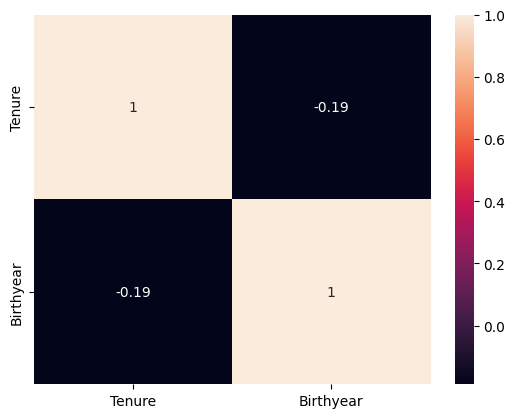

In [10]:
sns.heatmap(df[['Tenure', 'Birthyear']].corr('spearman'), annot = True)

Карта корреляции говорит о том, что зависимости между возрастом и длительностью статуса нет.

# Анализ целевой перменной

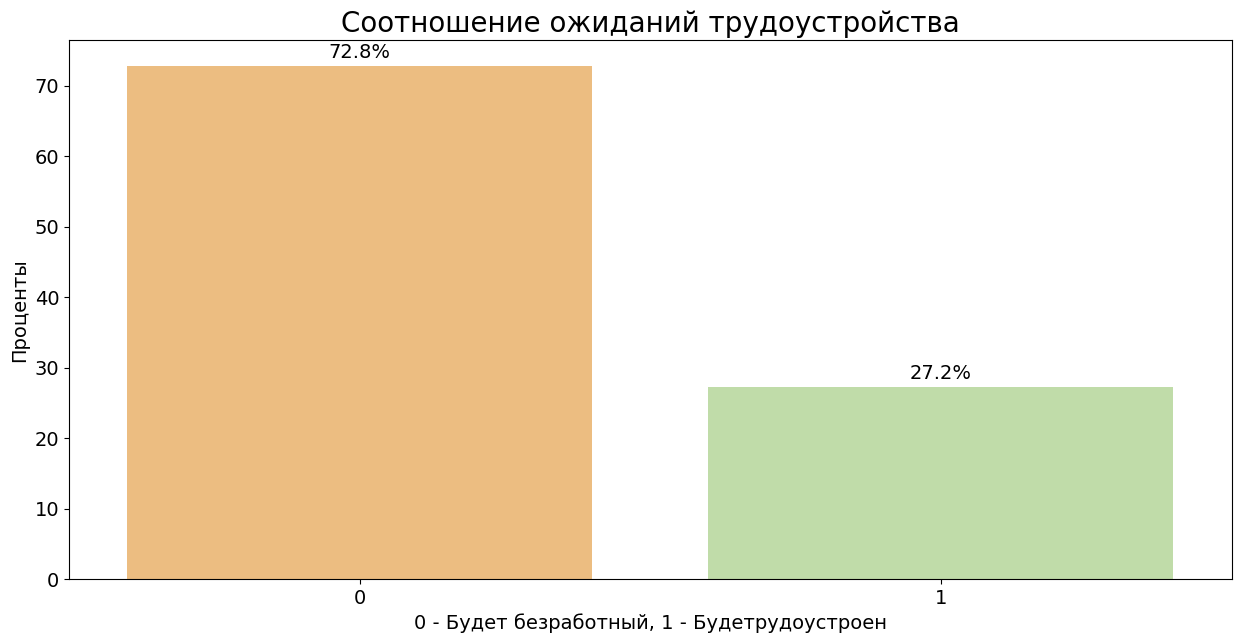

In [11]:
normalize_target(df[preproc['target_column']])

В датесете присутствует дисбаланс классов. Это необходимо учитывать при обучении моделей.

# Гипотезы

<b>Спиок гипотез</b><br><font color = '#000080'>
<i>1. Чем старше человек (чем меньше год рождения), тем более вероятно, что он будет трудоустроен в течение года.<br>
2. Чем выше уровень образования, тем более вероятно, что человек трудоустроен.<br>
3. В городе больше шансов быть трудоустроенным, чем в селе или пригороде.<br>
4. Среди женщин будет больше безработных, чем среди мужчин.<br>
5. Чем дольше человек не трудоустроен, тем скорее он найдёт работу.<br>
6. Если человек на момент опроса безработный, то он скорее всего, будет трудоустроен в течение года.<br>
7. Вероятность найти работу в течение года  в столичных провинциях выше, чем в остальных.<br>
8. Выпускники частных школ, которые меньше звисят от государства, будут трудоустроены в течение года.<br>
9. Люди с продвинутым знанием англиского будут трудоустроены в течение года.<br>
10. Базового знания англиского достаточно, чтобы быть трудоустроенным в течение года.<br>

В первую очередь взяты признаки, которые заполнены полностью и более 50%. Они более информативные.

<font color = '#000080' size = 3> <i><u>1. Чем старше человек (чем меньше год рождения), тем более вероятно, что он будет трудоустроен в течение года.

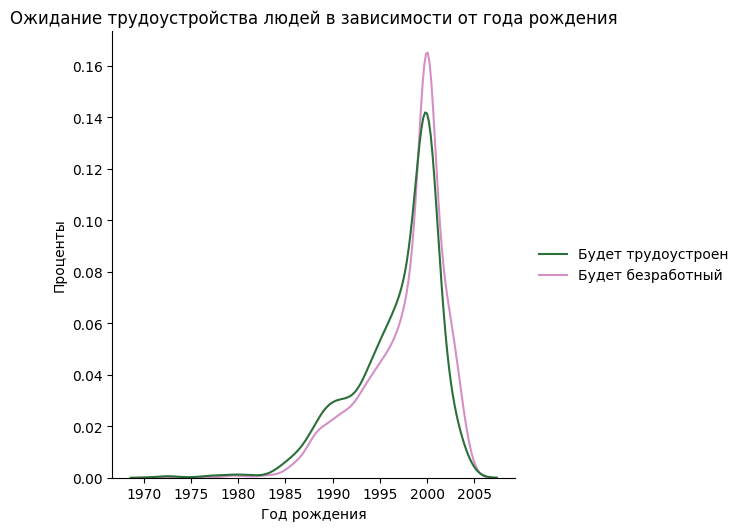

In [12]:
sns.displot(
    {
        "Будет трудоустроен": df[df.Target == 1].Birthyear,
        "Будет безработный": df[df.Target == 0].Birthyear,
    },
    common_norm=False,
    kind="kde",
    palette = 'cubehelix',
    height=5)
plt.title('Ожидание трудоустройства людей в зависимости от года рождения')
plt.xlabel('Год рождения')
plt.ylabel('Проценты')
plt.show()

Распределения в целом одинаковые, но среди родившихся до 2000 года побольше работающих, чем безработных, а среди тех, кто родился в 2000 году и позже, побольше безработных.
Принимаем гипотезу.

<font color = '#000080' size = 3> <i><u>2. Чем выше уровень образования, тем более вероятно, что человек трудоустроен.

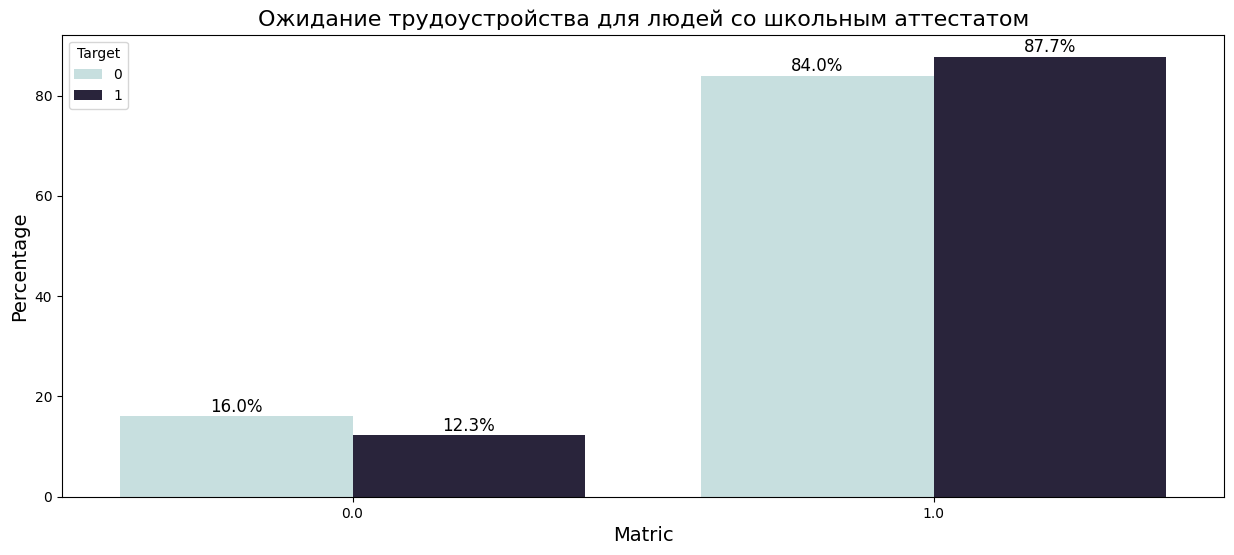

In [13]:
barplot_group(df, "Matric", preproc['target_column'], 'Ожидание трудоустройства для людей со школьным аттестатом')

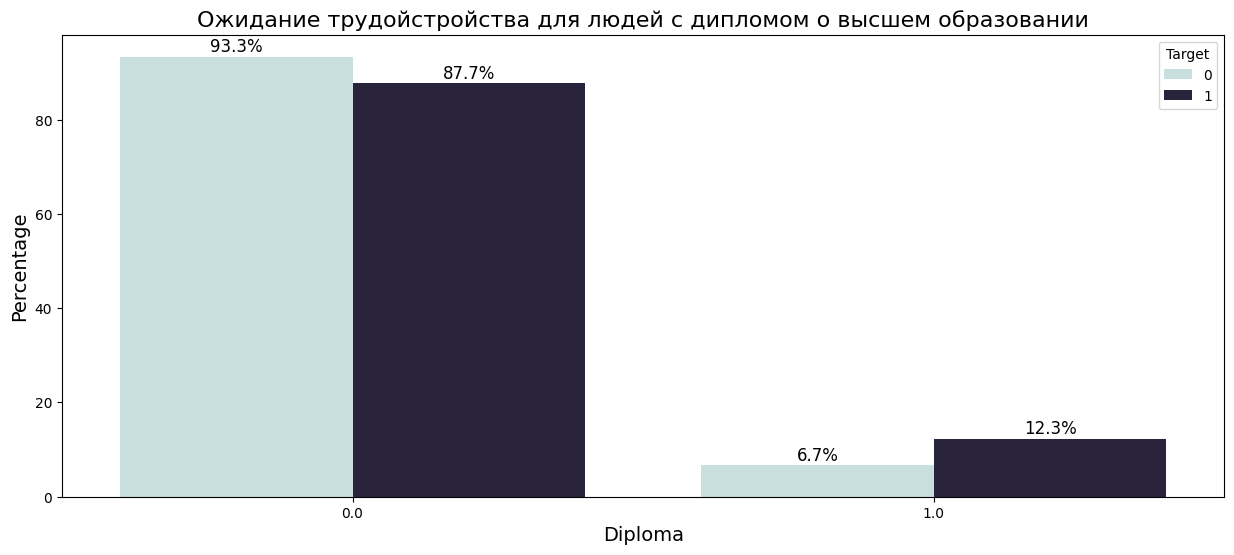

In [14]:
barplot_group(df, "Diploma", preproc['target_column'], 'Ожидание трудойстройства для людей с дипломом о высшем образовании')

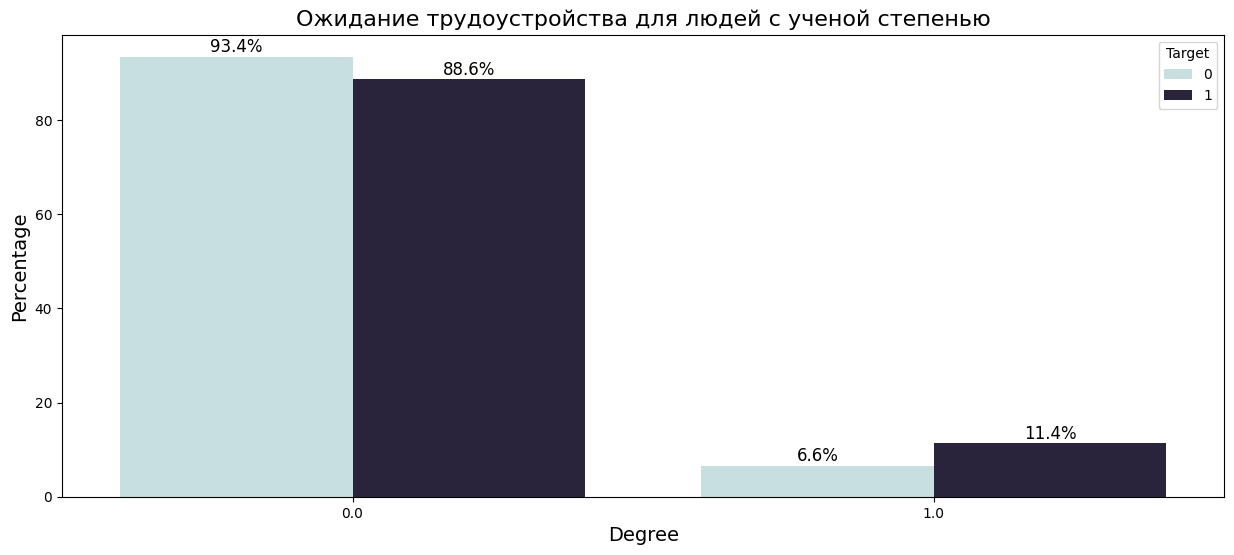

In [15]:
barplot_group(df, "Degree", preproc['target_column'], 'Ожидание трудоустройства для людей c ученой степенью')

In [16]:
check_chi2(df['Matric'], df[preproc['target_column']])
check_chi2(df['Diploma'], df[preproc['target_column']])
check_chi2(df['Degree'], df[preproc['target_column']])

chi2 statistic: 6.6725
p-value 0.0097909
Две категориальные переменные имеют значимую связь
chi2 statistic: 17.356
p-value 3.0996e-05
Две категориальные переменные имеют значимую связь
chi2 statistic: 13.022
p-value 0.00030784
Две категориальные переменные имеют значимую связь


Отвергаем гипотезу. Со школьным аттеатстом без прочего образования легче трудоустроиться, чем с высшим, и тем более степенью. Причем со школьным образованием прямая зависимость с прогнозом трудосутройства, а с высшим и степенью - обратная. Возможно, это связано с низким спросом на высококвалифициорванных специалистов в стране, но этот вопрос выходит за рамки данного исследования.

<font color = '#000080' size = 3> <i><u>3. В городе больше шансов быть трудоустроенным, чем в селе или пригороде.

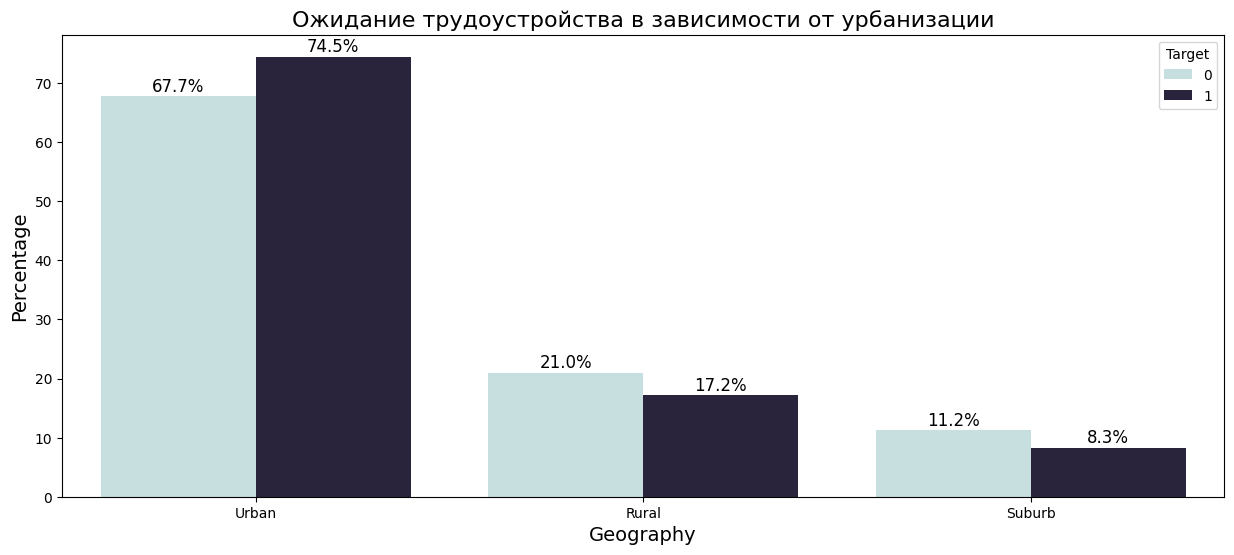

In [17]:
barplot_group(df, "Geography", preproc['target_column'], 'Ожидание трудоустройства в зависимости от урбанизации')

In [18]:
check_chi2(df['Geography'], df[preproc['target_column']])

chi2 statistic: 17.43
p-value 0.00016413
Две категориальные переменные имеют значимую связь


Принимаем гипотезу. Из графиков видно, что в городах количество трудоустроенных больше, чем безработных, а в пригородах и селах наоборот - больше безработных.

<font color = '#000080' size = 3> <i><u>4. Среди женщин больше безработных, чем среди мужчин.

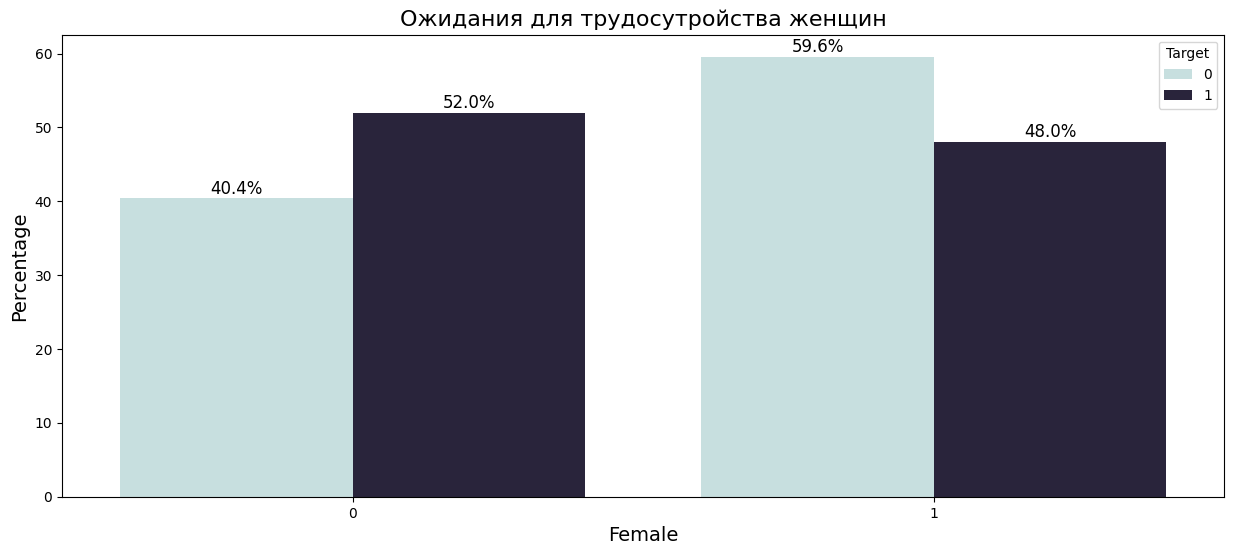

In [19]:
barplot_group(df, "Female", preproc['target_column'], 'Ожидания для трудосутройства женщин')

In [20]:
check_chi2(df['Female'], df[preproc['target_column']])

chi2 statistic: 42.716
p-value 6.3282e-11
Две категориальные переменные имеют значимую связь


Принимаем гипотезу. Среди безработных 60% женщин, а среди работающих 48%. Но это может быть не связано с тем, что женщин менее охотно берут на работу. До последних лет в африканской культуре для женщин престижнее было выйти замуж и родить ребёнка. Этот момент надо исследовать отдельно.

<font color = '#000080' size = 3> <i><u>5. Чем дольше человек не трудоустроен, тем скорее он найдёт работу.

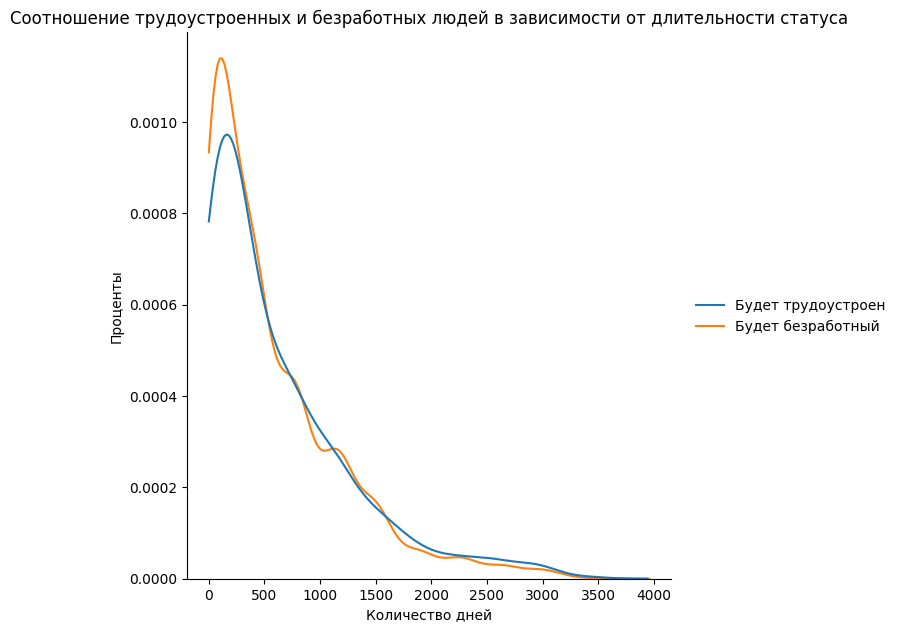

In [21]:
sns.displot(
    {
        "Будет трудоустроен": df[df.Target == 1].Tenure,
        "Будет безработный": df[df.Target == 0].Tenure,
    },
    common_norm=False,
    kind="kde",
    height=6,
    clip = (0, 4000),
    )

plt.title('Соотношение трудоустроенных и безработных людей в зависимости от длительности статуса')
plt.xlabel('Количество дней')
plt.ylabel('Проценты')
plt.show()

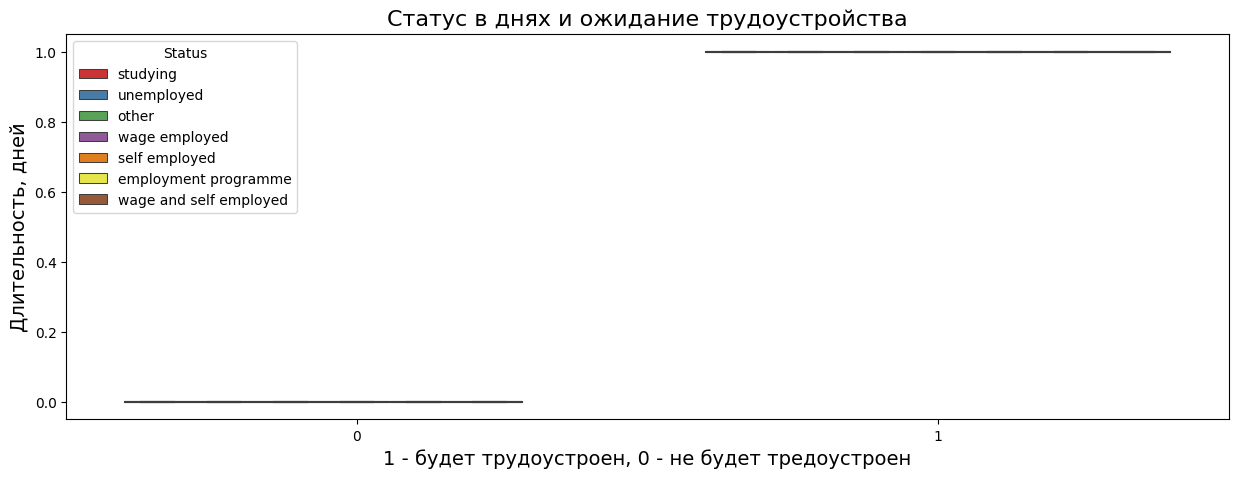

In [22]:
plt.figure(figsize=(15, 5))

ax = sns.boxplot(x='Target', y=preproc['target_column'], hue='Status', data=df, palette='Set1')
plt.title('Статус в днях и ожидание трудоустройства', fontsize=16)
plt.ylabel('Длительность, дней', fontsize=14)
plt.xlabel('1 - будет трудоустроен, 0 - не будет тредоустроен', fontsize=14)
plt.show()

Принимаем гипотезу. 
На графие плотности видно, что из тех, кто сменил статус менее 500 дней назад, меньше трудоустроенных.
Обратим внимание на вес этого признака, при обучении моделей.<br>
На боксплотах для тех безработных, кто в течение года найдет работу, выше в днях распределение и медиана. Это говорит о том, что чем дольше люди ищут работу, тем более вероятно, что они её найдут.

Eщё видим, что для статусов "учащийся", "другие" длительность статуса не указана. В контексте задачи заполним пропуски в признаке Tenure для этих статусов нулями.

In [23]:
df['Tenure'] = np.where(df.Status == 'studying', 0, df.Tenure)
df['Tenure'] = np.where(df.Status == 'other', 0, df.Tenure)
df.Tenure.isnull().sum()

150

Осталось всего лишь 150 пропусков, было примерно 1400

In [24]:
# Проверим ещё пропушенное значение на боксплоте, выведем строки по условию.
df.loc[(df['Status'] == 'wage and self employed') & (df['Target'] == 0)]

Empty DataFrame
Columns: [Person_id, Survey_date, Round, Status, Tenure, Geography, Province, Matric, Degree, Diploma, Schoolquintile, Math, Mathlit, Additional_lang, Home_lang, Science, Female, Sa_citizen, Birthyear, Birthmonth, Target]
Index: []

[0 rows x 21 columns]

Пустые строки говорят о том, что среди наемных работников, которые ещё + самозанятые, не ожидается безработных.
Этот фактор должен быть важным в обучении алгоритмов.

<font color = '#000080' size = 3> <i><u>6. Если человек на момент опроса безработный, то он скорее всего, будет трудоустроен в течение года.

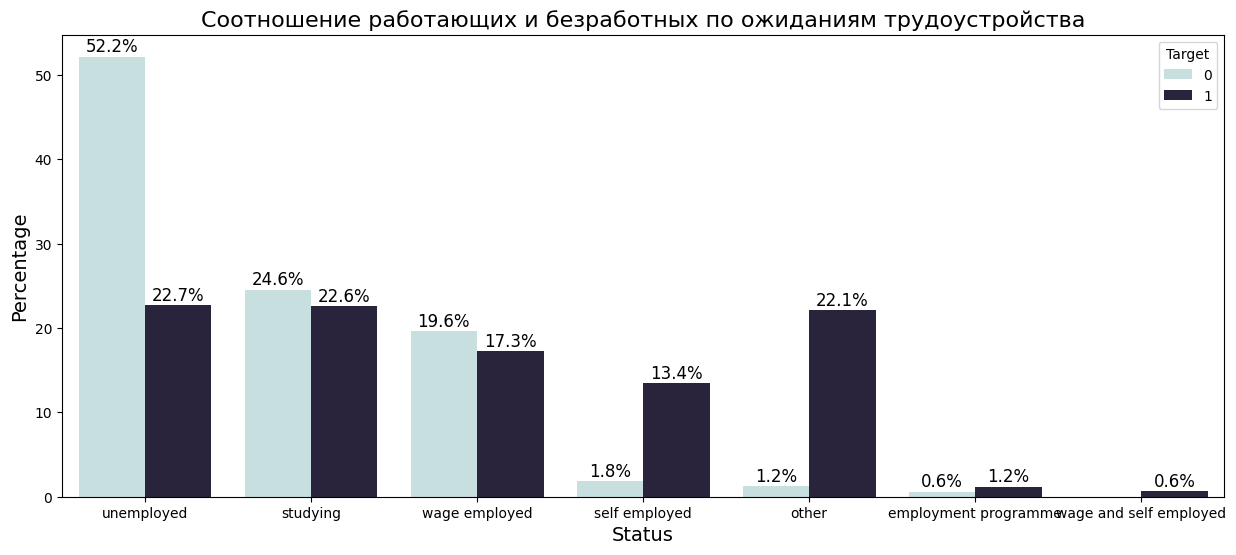

In [25]:
barplot_group(df, "Status", preproc['target_column'], 'Соотношение работающих и безработных по ожиданиям трудоустройства')

In [26]:
check_chi2(df['Status'], df[preproc['target_column']])

chi2 statistic: 902.2
p-value 1.2563e-191
Две категориальные переменные имеют значимую связь


Отвергаем гипотезу. Около 52% среди ожидаемых безработных - уже безработные.
Если человек безработный, то он скорее всего не найдет работу в течение года, если учится или наемный, то скорее потеряет.
Если самозанятый или занят прочей деятельностью, то, скорее всего, так и будет работать.
Заметим, что предыдущий вывод говорил о том, больше трудоустраиваются те, кто ищет работу более 500 дней, т.е. примерно от 1,5 лет.

<font color = '#000080' size = 3> <i><u>7. В ЮАР три столицы: законодательная Кейптаун (провинция Western Cape), административная Претория (провинция Gauteng), судебная Блумфонтейн (провинция Free State). Вероятность найти работу в течение года  в столичных провинциях выше, чем в остальных.

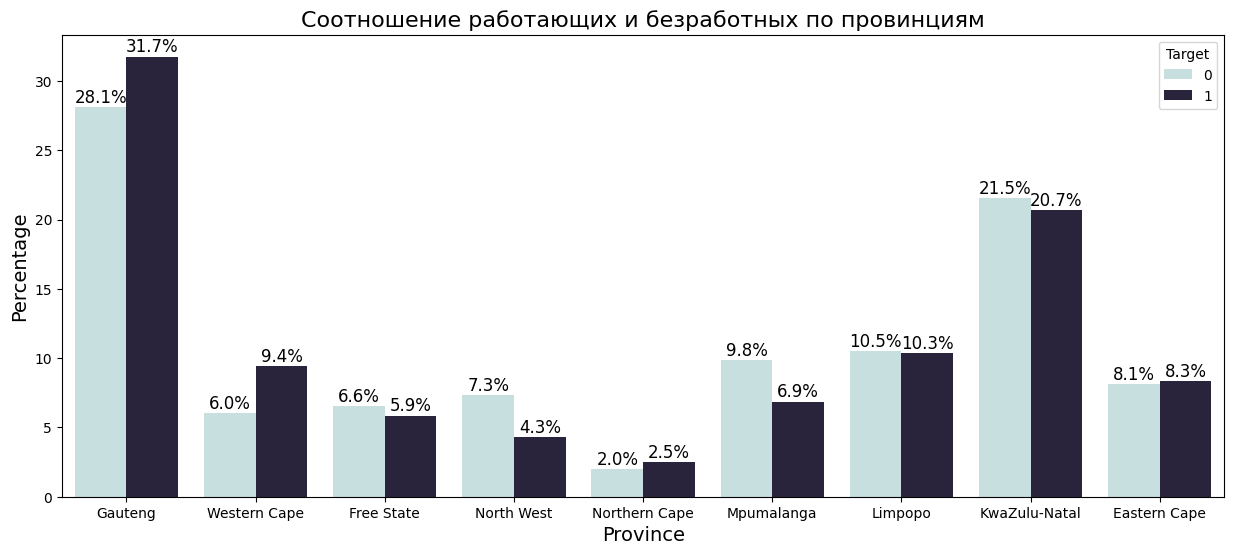

In [27]:
barplot_group(df, "Province", preproc['target_column'], 'Соотношение работающих и безработных по провинциям')

In [28]:
check_chi2(df['Province'], df[preproc['target_column']])

chi2 statistic: 37.718
p-value 8.4862e-06
Две категориальные переменные имеют значимую связь


Принимаем гипотезу. В провинциях Гаутенг и Вестерн Кейп явно больше ожидания трудоустройства, за счет чего в целом ожидание трудоустройства дает перевес, но во Фри Стейте вероятность трудоустройства меньше.

<font color = '#000080' size = 3> <i><u>8. Выпускники частных школ, которые меньше звисят от государства, будут трудоустроены в течение года.

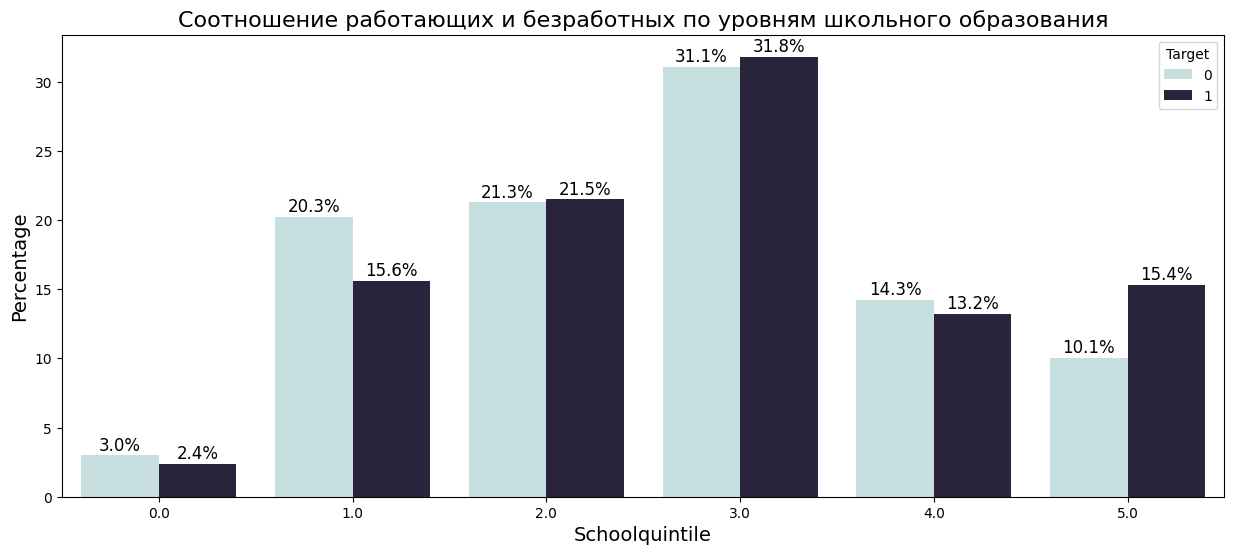

In [29]:
barplot_group(df, "Schoolquintile", preproc['target_column'], 'Соотношение работающих и безработных по уровням школьного образования')

In [30]:
check_chi2(df['Schoolquintile'], df[preproc['target_column']])

chi2 statistic: 18.685
p-value 0.0022001
Две категориальные переменные имеют значимую связь


Не принимаем гипотезу. Из барплота видно, что явно больше трудоутсроенных ожидается только после школ квантиля 5 (самые дорогие частные). У школ кваниля 4 ниже ожидание трудоустройства. У квантиля 3 ожидание трудоустройства выше.

<font color = '#000080' size = 3> <i><u>9.Люди с продвинутым знанием англиского будут трудоустроены в течение года.

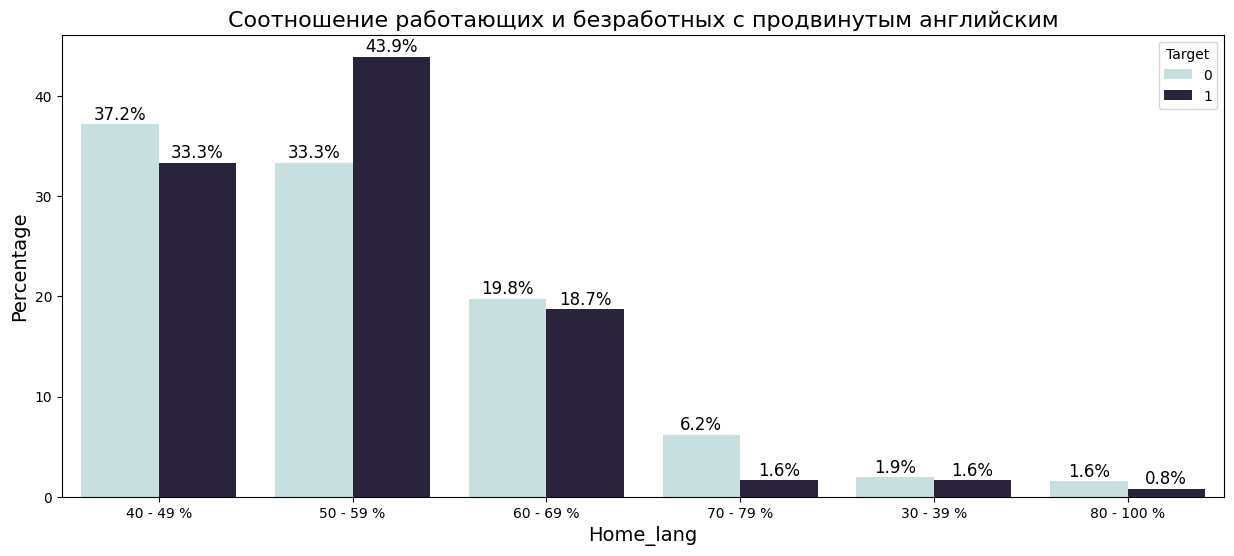

In [31]:
barplot_group(df, "Home_lang", preproc['target_column'], 'Соотношение работающих и безработных с продвинутым английским')

In [32]:
check_chi2(df['Home_lang'], df[preproc['target_column']])

chi2 statistic: 7.0091
p-value 0.21996
Две категориальные переменные не имеют значимой связи


Отвергаем гипотезу. На графике не видно связи и проверка хи-квадрат говорит о её отсутсвии.

<font color = '#000080' size = 3> <i><u>10. Базового знания англиского достаточно, чтобы быть трудоустроенным в течение года.

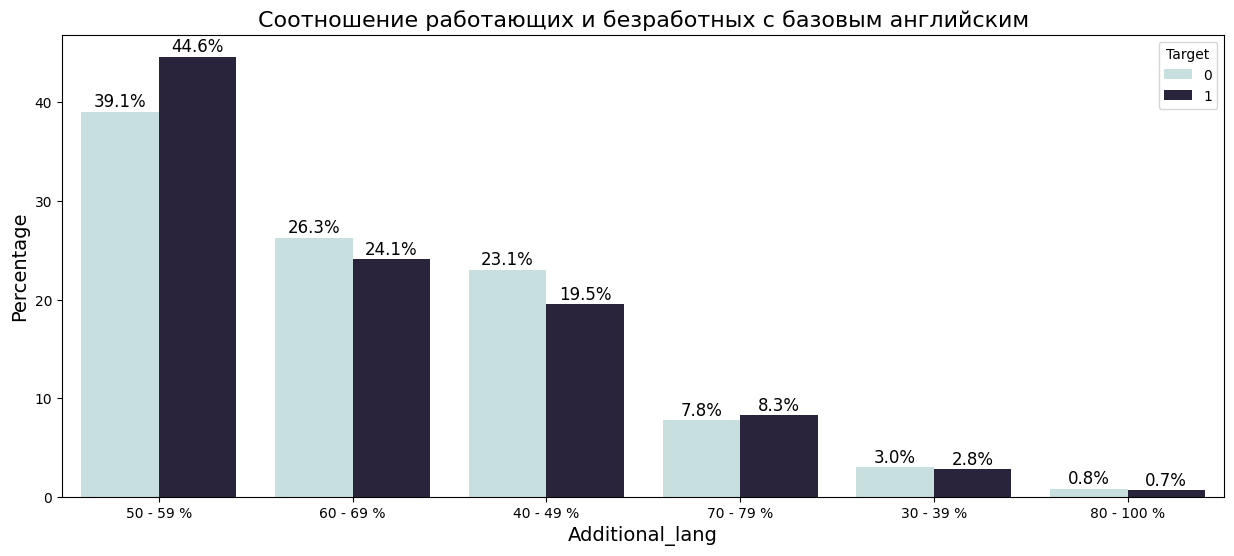

In [33]:
barplot_group(df, "Additional_lang", preproc['target_column'], 'Соотношение работающих и безработных с базовым английским')

In [34]:
check_chi2(df['Additional_lang'], df[preproc['target_column']])

chi2 statistic: 6.4603
p-value 0.26397
Две категориальные переменные не имеют значимой связи


Отвергаем гипотезу, зависимости нет.
С учетом предыдущей гипотезы, можно сделать вывод, что знание английского почти влияет на возможность трудоустройства

<b><font size = 3> По итогам разведочного анализа можно сделать вывод о том, что в ЮАР работу легко потерять и сложно найти.</b><br>
Особенно меньше вероятности, что трудоустроятся:
   - женщины
   - люди с высшим образованием и ученой степенью
   - деревенские  жители
   - молодые люди 2000 года рождения и младше
<br>

Уровень образования не дает никакой гарантии трудосутройства,в том числе частные школы, хорошее знание английского языка, высшее образование. Возможно, образованные люди эмигририуют из ЮАР в более развитые государства.<br>
Более всего необходима помощь государства в трудоустройстве молодым людям с высшим образованием.

# Обучение алгоритмов

Для MLOps взята более простая модель без стекинга, чтобы сократить время демонстрации.

<b><font size = 3> Подготовим данные для обучения.

In [35]:
dfl = fullfeat(df)

In [36]:
def save_input_data(
    data: pd.DataFrame, drop_columns: list, target_column: str, input_path: str
) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param drop_columns: список с признаками для удаления
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    input_df = data.drop(
        columns=drop_columns + [target_column], axis=1, errors="ignore"
    )
    # создаем словарь с уникальными значениями для ввода в UI
    # для того, чтобы типы данных не смешивались, во избежание ошибки, столбцы с числовыми значениями заполним нулями
    input_df[["Degree", "Diploma", "Schoolquintile", "Matric"]] = input_df[["Degree", \
              "Diploma", "Schoolquintile", "Matric"]].fillna(0.0)
    input_df = input_df.fillna("None")
    
    dict_input = {key: input_df[key].unique().tolist() for key in input_df.columns}
    with open(input_path, "w") as file:
        json.dump(dict_input, file)

In [37]:
save_input_data(
            data=dfl,
            drop_columns=preproc["drop_columns"],
            target_column=preproc["target_column"],
            input_path=preproc["input_path"],
        )

In [38]:
preproc['input_path']

'/home/basil/Downloads/mlops/data/processed/input_values.json'

In [39]:
dfl['Birthyear'] = np.log(df['Birthyear'] + 1)
dfl['Tenure'] = np.log(df['Tenure'])
dfl.loc[dfl['Tenure'] < 0, 'Tenure'] = 0.0
dfl['Tenure'] = dfl.Tenure.fillna(dfl.Tenure.mode()[0])

In [40]:
# Заполним пропуски в остальных признаках значением 'None', т.к. они либо категориальные, либо бинарные.
dfl = dfl.fillna('None')

In [41]:
# Переименуем колонку Female и значения.
dict_change_columns = preproc['map_change_columns']
dfl = replace_values(data=dfl, map_change_columns=dict_change_columns)

In [42]:
X = pd.get_dummies(dfl.drop([training['target_column']], axis=1))

# Целевая переменная (зависимая) Y - столбец с признаком, которые необходимо будет предсказать
y = dfl[training['target_column']]

In [43]:
# Разобъем датасет на тренировочные и тестовые данные и так как имеет место дизбаланс классов, 
#так же передаем параметр stratify = y, чтобы сохранить исходное соотношение классов в train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=preproc['test_size'], stratify=y, shuffle=True, random_state=preproc['random_state'])

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=preproc['test_size'],
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=preproc['random_state'])

dtrain = lgb.Dataset(X_train, label=y_train)
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
eval_set = [(X_val, y_val)]

<b> <font size = 3> Baseline

In [44]:
# Обучим бейзлайн
# Создаем эксземпляр класса бейзлайна
lgbm_ = LGBMClassifier(random_state=preproc['random_state'], scale_pos_weight=ratio, early_stopping_rounds=100)

# Обучаем алгоритм на бинаризованных данных
lgbm_.fit(X_train,
        y_train,
        eval_metric="auc",
        eval_set=eval_set)

# Потенцируем признаки
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

y_pred = lgbm_.predict(X_test)
y_score = lgbm_.predict_proba(X_test)

metrics = get_metrics_classification(y_test,
                               y_pred,
                               y_score,
                           name='LGBM_baseline_BIN')

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 874, number of negative: 2342
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 3216, number of used features: 67
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271766 -> initscore=-0.985680
[LightGBM] [Info] Start training from score -0.985680
Training u

Accuracy  ROC_AUC  Precision  Recall     f1  Logloss
model                                                                  
LGBM_baseline_BIN     0.756    0.794      0.552   0.562  0.557    0.499

In [45]:
# Сохраним модель
joblib.dump(lgbm_, training['model_path'])

['/home/basil/Downloads/mlops/models/lgb_baseline.joblib']

<b><font size = 3> Подбор лучших пареметров с помощью Optuna.

In [46]:
X['Birthyear'] = np.log(X['Birthyear'] + 1)
X['Tenure'] = np.log(X['Tenure'])

# Целевая функция для оптимизации параметров классификатора (оптюны)
def objective_lgb(trial, X, y, random_state=preproc['random_state']):
    
    lgb_params = {
        
        """Признаки для бинарной классификации с помощью алгоритма LGBM"""
        
        "n_estimators":
        trial.suggest_categorical("n_estimators", [700]),
        "verbosity": -1,
        # Добавлены новые признаки к тем, что в лекции для улучшения парметров
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.1]),
        "num_class": 1,
        "num_leaves":
        trial.suggest_int("num_leaves", 66, 66),
        "max_depth":
        trial.suggest_int("max_depth", 9, 9),
        "min_child_samples":
        trial.suggest_int("min_child_samples", 7, 7),
        "reg_alpha":
        trial.suggest_float("reg_alpha", 0.0038, 0.004, log=True),
        "gamma":
        trial.suggest_int("gamma", 2, 2),
        "reg_lambda":
        trial.suggest_float("reg_lambda", 4.8, 5.06, log=True),
        "min_split_gain":
        trial.suggest_int("min_split_gain", 1, 1),
        "subsample":
        trial.suggest_float("subsample", 0.8, 0.9),
        "subsample_freq":
        trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.98, 1.0),
        "objective":
        trial.suggest_categorical("objective", ["binary"]),
        "random_state":
        trial.suggest_categorical("random_state", [preproc['random_state']]),
        "boosting_type":
        "gbdt",
        "lambda_l1":
        trial.suggest_float("lambda_l1", 0.13, 0.18, log=True),
        "lambda_l2":
        trial.suggest_float("lambda_l2", 0.0095, 0.014, log=True),
        "feature_fraction":
        trial.suggest_float("feature_fraction", 0.78, 0.8),
    }
    
    
    N_FOLDS = training['n_folds']
    cv = KFold(n_splits=N_FOLDS, shuffle=True)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # параметр для стрижки деревьев алгоритма LGBMClassificier
    pruning_callback = LightGBMPruningCallback(trial, "binary_logloss")
    model = LGBMClassifier(**lgb_params,
                           early_stopping_rounds=100,
                           scale_pos_weight=ratio)
    
    # обучаем модель                       
    model.fit(X_train,
              y_train,
              eval_metric="auc",
              eval_set=[(X_test, y_test)],
              callbacks=[pruning_callback,
                         lgb.early_stopping(100)])

    preds = model.predict(X_test)
    cv_predicts[idx] =  roc_auc_score(y_test, preds)
    return np.mean(cv_predicts)

In [47]:
# Улучшаем параметры с помощью optuna
study = optuna.create_study(direction="minimize", study_name="LGB")
optuna.logging.set_verbosity(optuna.logging.WARNING)
func = lambda trial: objective_lgb(trial, X_train, y_train, random_state=preproc['random_state'])

[I 2023-10-29 13:59:27,985] A new study created in memory with name: LGB


In [48]:
# Передаем функцию с обучением в optuna
study.optimize(func, n_trials=5, show_progress_bar=True)
plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.823952	valid_0's binary_logloss: 0.479959
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.812999	valid_0's binary_logloss: 0.467866
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.785668	valid_0's binary_logloss: 0.499322


In [49]:
# Создаем экземпляр класса для обучения на лучших параметрах
lgbm_best = LGBMClassifier(**study.best_params, early_stopping_rounds=100, scale_pos_weight=ratio, verbosity=-1)
lgbm_best.fit(X_train,
             y_train,
             eval_set=eval_set,
             eval_metric='auc',
             )

LGBMClassifier(colsample_bytree=0.9819977791185542, early_stopping_rounds=100,
               feature_fraction=0.7953374143500712, gamma=2,
               lambda_l1=0.1548541020687405, lambda_l2=0.010904396852936449,
               max_depth=9, min_child_samples=7, min_split_gain=1,
               n_estimators=700, num_leaves=66, objective='binary',
               random_state=10, reg_alpha=0.00396380053510502,
               reg_lambda=4.988985199122626, scale_pos_weight=2.679633867276888,
               subsample=0.8322272180184171, subsample_freq=1, verbosity=-1)

In [50]:
# Потенцируем признаки для сравнения результатов обучения
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

y_pred = lgbm_best.predict(X_test)
y_score = lgbm_best.predict_proba(X_test)

In [51]:
# Выведем получившиеся метрики
metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test,
                               y_pred,
                               y_score,
                               name='LGBM_tuned')])

round(metrics.set_index('model'), 3)

Accuracy  ROC_AUC  Precision  Recall     f1  Logloss
model                                                                  
LGBM_baseline_BIN     0.756    0.794      0.552   0.562  0.557    0.499
LGBM_tuned            0.760    0.804      0.557   0.584  0.570    0.489

In [52]:
# Сохраним модель
joblib.dump(lgbm_best, training['study_path'])

['/home/basil/Downloads/mlops/models/lgb_optuna.joblib']

In [53]:
# Проверим на переобучение
check_overfitting(model=lgbm_best,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  metric_fun=roc_auc_score)

roc_auc_score train: 0.964
roc_auc_score test: 0.804
delta = 19.9 %


In [54]:
# Сохраним метрики
metrics_path = training['metrics_path']

metrics = get_metrics(X_train, X_test, y_test, lgbm_best.predict(X_test), \
                      lgbm_best.predict_proba(X_test), y_train=y_train, model=lgbm_best)
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

Модель явно переобучилась, для борьбы можноиспользовать стекинг, но для упрощения оставим получившиеся результаты. К тому же удаломсь подобрать параметры, при которых, несомтря на переобучение, метрики всегда лучше, чем при бейзлайне.

In [55]:
# Запишем в файл лучшие параметры
best_params = training['params_path']

with open(best_params, 'w') as f:
    json.dump(study.best_params, f)

In [56]:
def save_unique_train_data(
    data: pd.DataFrame, drop_columns: list, target_column: str, unique_values_path: str
) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param drop_columns: список с признаками для удаления
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = data.drop(
        columns=drop_columns + [target_column], axis=1, errors="ignore"
    )
    # создаем словарь с уникальными значениями для сравнения вводимых данных
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)

In [57]:
save_unique_train_data(
    data=X,
    drop_columns=preproc["drop_columns"],
    target_column=preproc["target_column"],
    unique_values_path=preproc["unique_values_path"],
)

In [58]:
preproc['unique_values_path']

'/home/basil/Downloads/mlops/data/processed/unique_values.json'

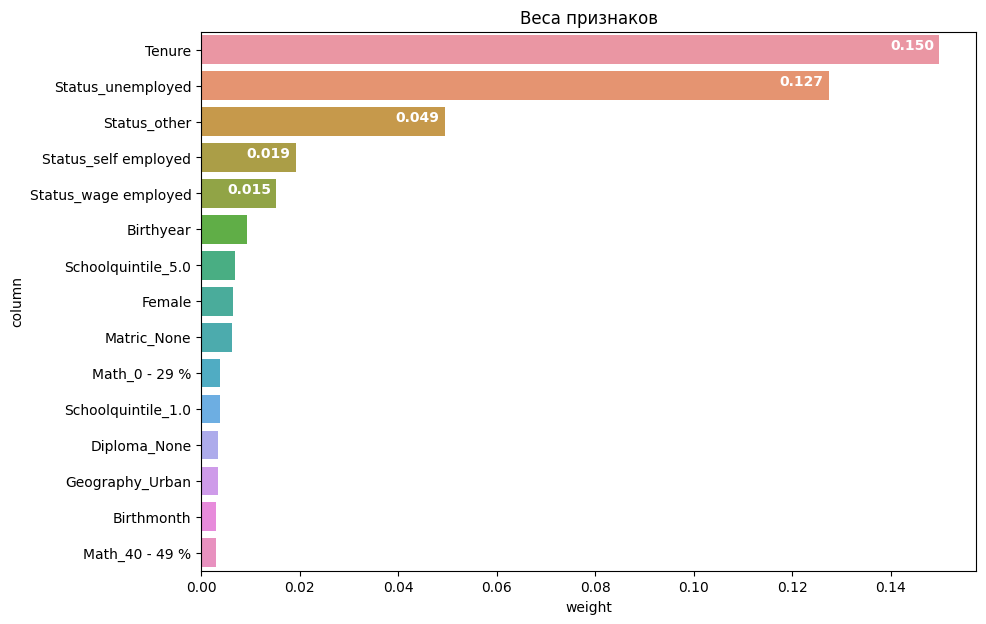

In [59]:
# Выведем наиболее значимые признаки, веса на график
r = permutation_importance(lgbm_best,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=preproc['random_state'])
feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['weight'] = r['importances_mean']

feature_imp.sort_values(by='weight', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
plt.title('Веса признаков', fontsize=12)
sns.barplot(data=feature_imp[:15], x='weight', y='column')

# Выведем значения весов на бары
for index, value in enumerate((feature_imp['weight'])):
    label = format(f"{value:.3f}")
    plt.annotate(label, xy = (value-0.01, index), color='white',fontweight='bold')

Наиболее весомый признак - длительность статуса. Потом идет статус - безработный или занятый.<br>
В разевдочном анализе эти признаки были важны:
длительность статуса (кто дольше безработный, тот скорее устроится, и у кого маленький стаж, у того больше шансов потерять работу), статус (тот, кто уже работает по найму или на себя, так и будет работать, а кто безарботный, тот с трудом найдет и в течение года потеряет).<br>
Так же уровни образования мало значимы для определения целевого признака, как и в разведочном анализе.

<b> Сравнение результатов бейзлайна и оптюны на матрице ошибок

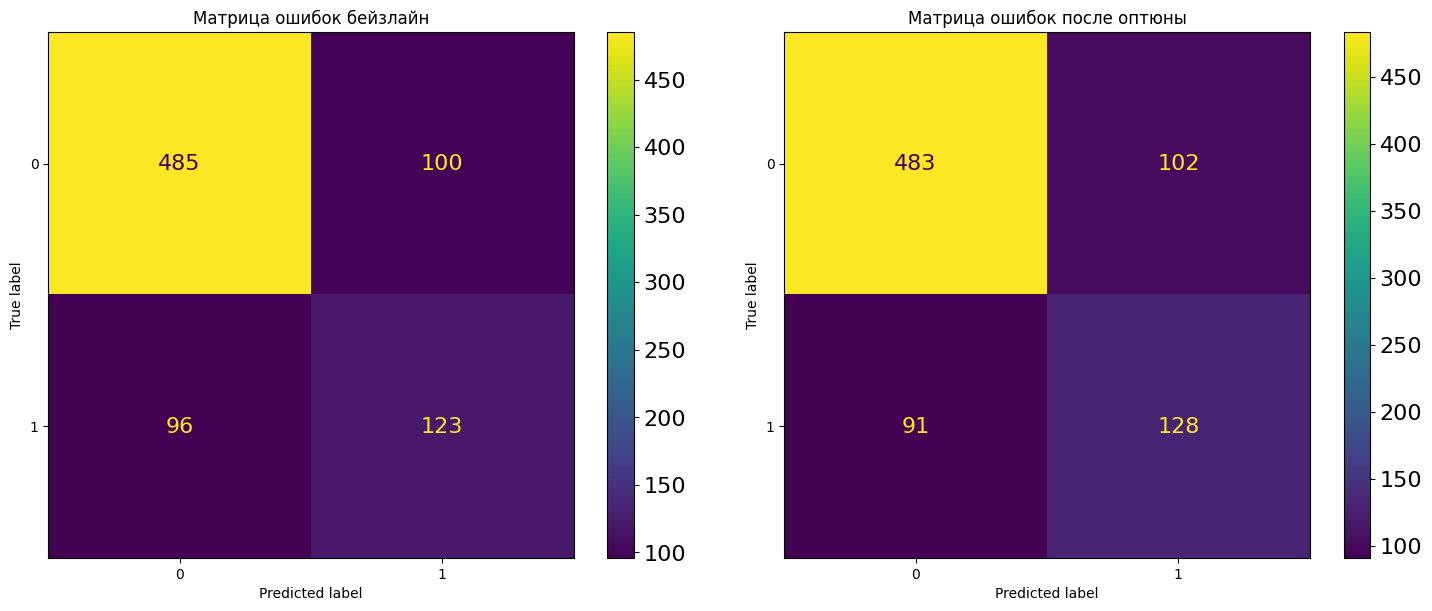

In [60]:
duomatrix(y_test=y_test, X_test=X_test, model1=lgbm_, model2=lgbm_best, \
          title1='Матрица ошибок бейзлайн', title2='Матрица ошибок после оптюны')

Задача в данном исследовании - точнее угадать класс 0 - кто будет безработный. Несмотря на лучшие метрики, бейзлайн на тестовых данных, лучше справился с данной задачей, чем модель на лучших параметрах.